<a href="https://colab.research.google.com/github/tanyasheru23/PyTorch/blob/main/NNClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

## Make Classification Data and get ready

The `make_circles()` method from Scikit-Learn to generate two circles with different coloured dots.

In [3]:
n_samples = 2000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)

In [4]:
len(X), len(y)

(2000, 2000)

In [5]:
print(f"First 5 samples of X: \n{X[:5]}\n")
print(f"First 5 samples of y: \n{y[:5]}")

First 5 samples of X: 
[[ 0.47109875 -0.58158579]
 [-0.61696058  0.80818956]
 [-0.3999557   0.70796779]
 [ 0.82938523 -0.60057314]
 [-0.16419138  0.76128858]]

First 5 samples of y: 
[1 0 1 0 1]


In [6]:
# Make a data frame of circle data
circles = pd.DataFrame({'X1': X[:, 0],
                        'X2': X[:, 1],
                       'label': y})
circles.head()

,X1,X2,label
0,0.471099,-0.581586,1
1,-0.616961,0.808190,0
2,-0.399956,0.707968,1
3,0.829385,-0.600573,0
4,-0.164191,0.761289,1


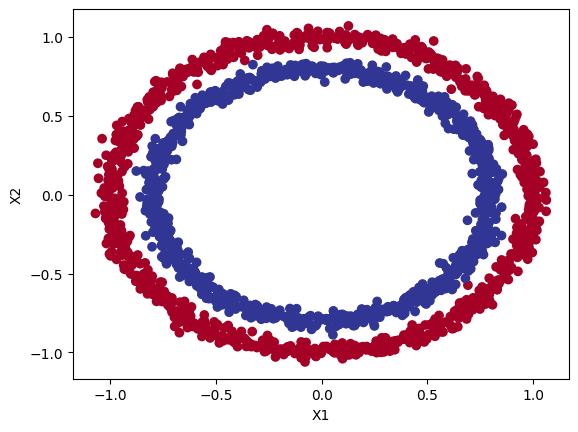

In [7]:
plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [8]:
X.shape, y.shape

((2000, 2), (2000,))

In [9]:
# Check different labels
circles.label.value_counts()

1    1000
0    1000
Name: label, dtype: int64

Turn data into tensors

In [10]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [11]:
X[:5], y[:5]

(tensor([[ 0.4711, -0.5816],
         [-0.6170,  0.8082],
         [-0.4000,  0.7080],
         [ 0.8294, -0.6006],
         [-0.1642,  0.7613]]),
 tensor([1., 0., 1., 0., 1.]))

In [12]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [13]:
torch.manual_seed(42)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size = 0.2, random_state = 42)

In [15]:
len(X_train), len(X_test)

(1600, 400)

## Building a Model

Build a model for classification

To do so, we need or have to
1. Setup device agnostic code, to run our code on an accelerator(GPU), if there is one
2. Construct a model
3. Define a loss function and optimizer
4. Create a training and testing loop

### Device Agnostic Code

In [16]:
# Make a device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Construct a Model

Let's create a model class that:

1. Subclasses `nn.Module` (almost all PyTorch models are subclasses of nn.Module).
2. Creates 2 `nn.Linear` layers in the constructor capable of handling the input and output shapes of X and y.
3. Defines a `forward()` method containing the forward pass computation of the model.
4. Instantiates the model class and sends it to the target device.

In [17]:
class NNCircleClassifier(nn.Module):
  def __init__(self, in_features, h1, out_features):
    super().__init__()
    self.layer1 = nn.Linear(in_features, h1)
    self.layer2 = nn.Linear(h1, out_features)

    # self.two_linear_layers = nn.Sequential(
    #     nn.Linear(in_features = 2, outfeatures = 5),
    #     nn.Linear(in_features = 5, out_features = 1)
    #     )

  def forward(self, x):
    x = (self.layer1(x))
    x = (self.layer2(x))

    return x

In [18]:
model_0 = NNCircleClassifier(in_features = 2, h1 = 5, out_features = 1).to(device)
model_0

NNCircleClassifier(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
model_0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('layer1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('layer2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('layer2.bias', tensor([-0.2060], device='cuda:0'))])

In [20]:
# model_0 = nn.Sequential(
#     nn.Linear(in_features = 2, outfeatures = 5),
#     nn.Linear(in_features = 5, out_features = 1)
# ).to(device)

### Device Loss Function and Optimizer

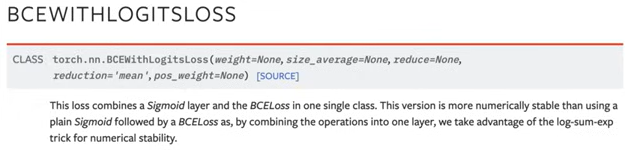

In [21]:
# loss_fn = nn.BCELoss() --> this requires inputs to have gone through the sigmoid activation function prior to input going through BCE
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.01)

Define Accuracy Function

In [22]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

### Training Model

1. Set up training mode
2. Forward Pass
3. Calculate the Loss
4. Optimizer zero grad
5. Loss Backward
6. Optimizer Step

Going from *raw logits* ⟶ *prediction probabilities* ⟶ *prediction labels*

Our model outputs are going to be raw logits.

We have to convert them into **prediction probs** by passing them into some kind of activation function (e.g. sigmoid for BCE and softmax for for multiclass).

Then we we can convert *prediction probs* ⟶ *prediction labels* by either rounding them or taking the `argmax()`


In [23]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0((X_test.to(device))[:5])
y_logits

tensor([[-0.1843],
        [-0.1976],
        [-0.2067],
        [-0.1759],
        [-0.0865]], device='cuda:0')

In [24]:
y_test[:5]

tensor([1., 1., 0., 1., 0.])

Use the sigmoid activation function on output logits, to turn them into pred probs

In [25]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4541],
        [0.4508],
        [0.4485],
        [0.4561],
        [0.4784]], device='cuda:0')

For  our *pred prob* values, we need to perform a range-style rounding on them:


*   `y_pred_probs` `> =` `0.5` ⟹ `y=1` (class 1)
*   `y_pred_probs` `< ` `0.5` ⟹ `y=0` (class 0)



In [26]:
y_preds = torch.round(y_pred_probs)

# in one go
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)[:5])))

y_pred_labels

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<RoundBackward0>)

Building a Training Loop and a Testing Loop

In [27]:
torch.manual_seed(42)

epochs = 100
# batch_size = 32

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epoch_count = []
train_losses = []
test_losses = []
train_accs = []
test_accs = []
for epoch in range(epochs):

  model_0.train()

  # 1. Forward Pass
  y_logits = model_0.forward(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate Loss / accuracy
  # loss = nn.BCELoss(torch.sigmoids(y_logits), # nn.BCE expects prediction probabilities as input
  #                   y_train)
  loss = loss_fn(y_logits,
                 y_train) # remember nn.BCEwithLogits expects raw logits as it performs sigmoid by itself
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)
  epoch_count.append(epoch)
  train_losses.append(loss)
  train_accs.append(acc)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss Backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():

    # 1. Forward Pass
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate Loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_preds)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Train Loss: {loss: .5f}, | Train Acc: {acc: .2f}% | Test loss: {test_loss: .5f}, | Test Acc: {test_acc: .2f}%")

Epoch: 0 | Train Loss:  0.69567, | Train Acc:  50.19% | Test loss:  0.69747, | Test Acc:  49.25%
Epoch: 10 | Train Loss:  0.69547, | Train Acc:  50.19% | Test loss:  0.69722, | Test Acc:  49.25%
Epoch: 20 | Train Loss:  0.69528, | Train Acc:  50.19% | Test loss:  0.69699, | Test Acc:  49.25%
Epoch: 30 | Train Loss:  0.69510, | Train Acc:  50.19% | Test loss:  0.69678, | Test Acc:  49.25%
Epoch: 40 | Train Loss:  0.69495, | Train Acc:  50.19% | Test loss:  0.69659, | Test Acc:  49.25%
Epoch: 50 | Train Loss:  0.69481, | Train Acc:  50.19% | Test loss:  0.69641, | Test Acc:  49.25%
Epoch: 60 | Train Loss:  0.69468, | Train Acc:  50.19% | Test loss:  0.69625, | Test Acc:  49.25%
Epoch: 70 | Train Loss:  0.69456, | Train Acc:  50.19% | Test loss:  0.69610, | Test Acc:  49.25%
Epoch: 80 | Train Loss:  0.69446, | Train Acc:  50.19% | Test loss:  0.69596, | Test Acc:  49.25%
Epoch: 90 | Train Loss:  0.69436, | Train Acc:  50.19% | Test loss:  0.69583, | Test Acc:  49.25%


In [46]:
import matplotlib.pyplot as plt

def plot_decision_boundary(model, X, y):
  X, y = X.to("cpu"), y.to("cpu") # CPU works better with NumPy and Matplotlib

  # setup prediction boundaries
  x1_min, x1_max = X[:, 0].min() - 0.1, X[:,0].max() + 0.1
  x2_min, x2_max = X[:, 1].min() - 0.1, X[:,1].max() + 0.1
  x1_ = np.linspace(x1_min, x1_max, 101) # creates evenly spaced 101 points between min and max
  x2_ = np.linspace(x2_min, x2_max, 101)
  x1x1, x2x2 = np.meshgrid(x1_, x2_)     # creates a meshgrid --> useful for contour plot

  xx1_ravel = x1x1.ravel()
  xx2_ravel = x2x2.ravel()
  # np.column_stack((x1_, x2_)) --> will simply add x2_ beside x1 and size is 101
  # np.column_stack(xx1_ravel, xx2_ravel) --> will add each element of x2_ beside each element of x1_ and size is 10201
                                              # because size of xx1 is 10201 which is flattened version of meshgrid
  # Make features
  X_to_pred_on = torch.from_numpy(np.column_stack((xx1_ravel, xx2_ravel))).float().to(device) # taking each x1 and x2 to create feature values

  # make predictions
  model.eval()
  with torch.inference_mode():
    y_logits = model(X_to_pred_on)

  # Test for multiclass of binary
  if (len(torch.unique(y)) > 2):
    y_pred = torch.softmax(y_logits, dim = 1).argmax(dim=1)
  else:
    y_pred = torch.round(torch.sigmoid(y_logits)) #binary

  y_pred = y_pred.reshape(x1x1.shape).detach().cpu().numpy()
  plt.contourf(x1x1, x2x2, y_pred, cmap = plt.cm.RdYlBu, alpha = 0.7)
  plt.scatter(X[:,0], X[:,1], c = y, s = 40, cmap = plt.cm.RdYlBu)
  plt.xlim(x1x1.min(), x1x1.max())
  plt.ylim(x2x2.min(), x2x2.max())

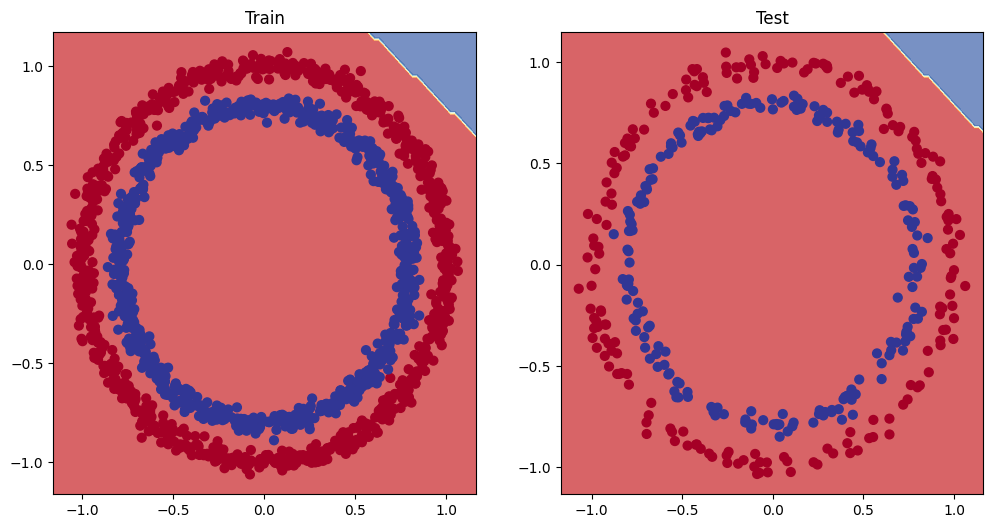

In [47]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Improving our model

* Add more layers
* Add more nuerons in hidden units
* Change the activation functions
* Change the learning rate
* Change the loss function

In [48]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer3 = nn.Linear(in_features = 10, out_features = 1)

  def forward(self, x):
    x = self.layer1(x)
    x = F.relu(x)
    x = self.layer2(x)
    x = F.relu(x)
    x = self.layer3(x)

    return x

In [49]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [50]:
model_1.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, 

In [51]:

# loss_fn = nn.BCELoss() --> this requires inputs to have gone through the sigmoid activation function prior to input going through BCE
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.1)

In [52]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [53]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epoch_count = []
train_losses = []
test_losses = []
train_accs = []
test_accs = []
for epoch in range(epochs):

  model_1.train()

  # 1. Forward Pass
  y_logits = model_1.forward(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate Loss / accuracy
  # loss = nn.BCELoss(torch.sigmoids(y_logits), # nn.BCE expects prediction probabilities as input
  #                   y_train)
  loss = loss_fn(y_logits,
                 y_train) # remember nn.BCEwithLogits expects raw logits as it performs sigmoid by itself
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)
  epoch_count.append(epoch)
  train_losses.append(loss)
  train_accs.append(acc)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss Backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():

    # 1. Forward Pass
    test_logits = model_1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate Loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_preds)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

  if epoch % 50 == 0:
    print(f"Epoch: {epoch} | Train Loss: {loss: .5f}, | Train Acc: {acc: .2f}% | Test loss: {test_loss: .5f}, | Test Acc: {test_acc: .2f}%")

Epoch: 0 | Train Loss:  0.69301, | Train Acc:  49.81% | Test loss:  0.69279, | Test Acc:  50.75%
Epoch: 50 | Train Loss:  0.69172, | Train Acc:  53.00% | Test loss:  0.69170, | Test Acc:  52.25%
Epoch: 100 | Train Loss:  0.69094, | Train Acc:  52.62% | Test loss:  0.69104, | Test Acc:  52.50%
Epoch: 150 | Train Loss:  0.69016, | Train Acc:  52.31% | Test loss:  0.69036, | Test Acc:  53.75%
Epoch: 200 | Train Loss:  0.68929, | Train Acc:  53.00% | Test loss:  0.68955, | Test Acc:  53.00%
Epoch: 250 | Train Loss:  0.68828, | Train Acc:  53.56% | Test loss:  0.68859, | Test Acc:  52.75%
Epoch: 300 | Train Loss:  0.68702, | Train Acc:  53.25% | Test loss:  0.68740, | Test Acc:  52.75%
Epoch: 350 | Train Loss:  0.68536, | Train Acc:  53.44% | Test loss:  0.68587, | Test Acc:  52.50%
Epoch: 400 | Train Loss:  0.68325, | Train Acc:  53.62% | Test loss:  0.68411, | Test Acc:  52.75%
Epoch: 450 | Train Loss:  0.68071, | Train Acc:  54.44% | Test loss:  0.68202, | Test Acc:  53.00%
Epoch: 500 | 

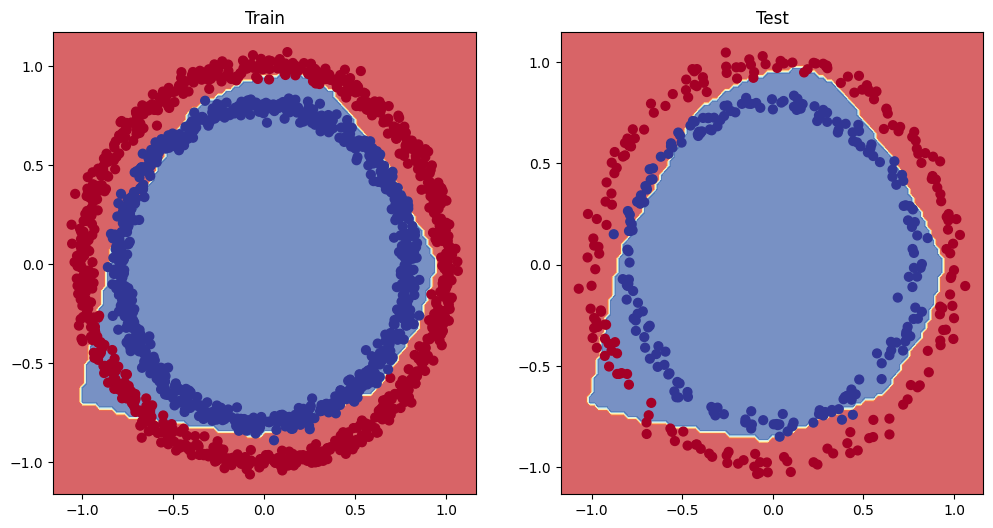

In [54]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## The missing piece - Non- Linearity

Neural Networks, rather than us telling the mdel what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own

And these tools are linear & non-linear functions.

In [55]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features = 2, out_features = 15)
    self.layer2 = nn.Linear(in_features = 15, out_features = 10)
    self.layer3 = nn.Linear(in_features = 10, out_features = 1)

  def forward(self, x):
    x = self.layer1(x)
    x = F.relu(x)
    x = self.layer2(x)
    x = F.relu(x)
    x = self.layer3(x)

    return x

In [56]:
model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=15, bias=True)
  (layer2): Linear(in_features=15, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [57]:
# loss_fn = nn.BCELoss() --> this requires inputs to have gone through the sigmoid activation function prior to input going through BCE
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_2.parameters(),
                            lr = 0.1)

In [58]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [59]:

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epoch_count = []
train_losses = []
test_losses = []
train_accs = []
test_accs = []
for epoch in range(epochs):

  model_2.train()

  # 1. Forward Pass
  y_logits = model_2.forward(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate Loss / accuracy
  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)
  epoch_count.append(epoch)
  train_losses.append(loss)
  train_accs.append(acc)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss Backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():

    # 1. Forward Pass
    test_logits = model_2(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate Loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_preds)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

  if epoch % 50 == 0:
    print(f"Epoch: {epoch} | Train Loss: {loss: .5f}, | Train Acc: {acc: .2f}% | Test loss: {test_loss: .5f}, | Test Acc: {test_acc: .2f}%")

Epoch: 0 | Train Loss:  0.69686, | Train Acc:  49.81% | Test loss:  0.69498, | Test Acc:  50.75%
Epoch: 50 | Train Loss:  0.68980, | Train Acc:  62.94% | Test loss:  0.69014, | Test Acc:  61.50%
Epoch: 100 | Train Loss:  0.68797, | Train Acc:  57.38% | Test loss:  0.68865, | Test Acc:  54.75%
Epoch: 150 | Train Loss:  0.68591, | Train Acc:  58.13% | Test loss:  0.68673, | Test Acc:  55.50%
Epoch: 200 | Train Loss:  0.68344, | Train Acc:  60.31% | Test loss:  0.68431, | Test Acc:  59.50%
Epoch: 250 | Train Loss:  0.68070, | Train Acc:  64.75% | Test loss:  0.68172, | Test Acc:  63.00%
Epoch: 300 | Train Loss:  0.67758, | Train Acc:  66.69% | Test loss:  0.67869, | Test Acc:  66.00%
Epoch: 350 | Train Loss:  0.67380, | Train Acc:  67.06% | Test loss:  0.67499, | Test Acc:  66.75%
Epoch: 400 | Train Loss:  0.66897, | Train Acc:  67.88% | Test loss:  0.67027, | Test Acc:  68.00%
Epoch: 450 | Train Loss:  0.66272, | Train Acc:  69.38% | Test loss:  0.66413, | Test Acc:  71.00%
Epoch: 500 | 

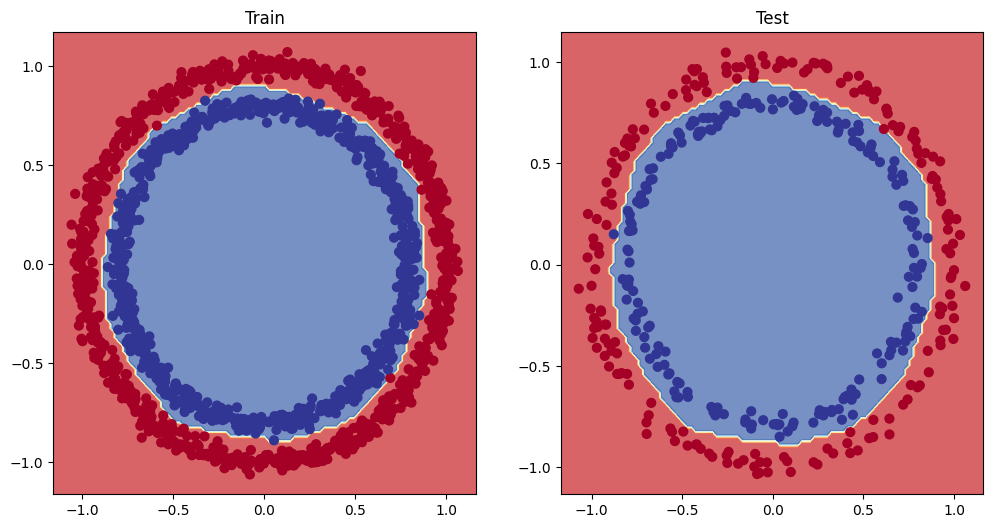

In [60]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

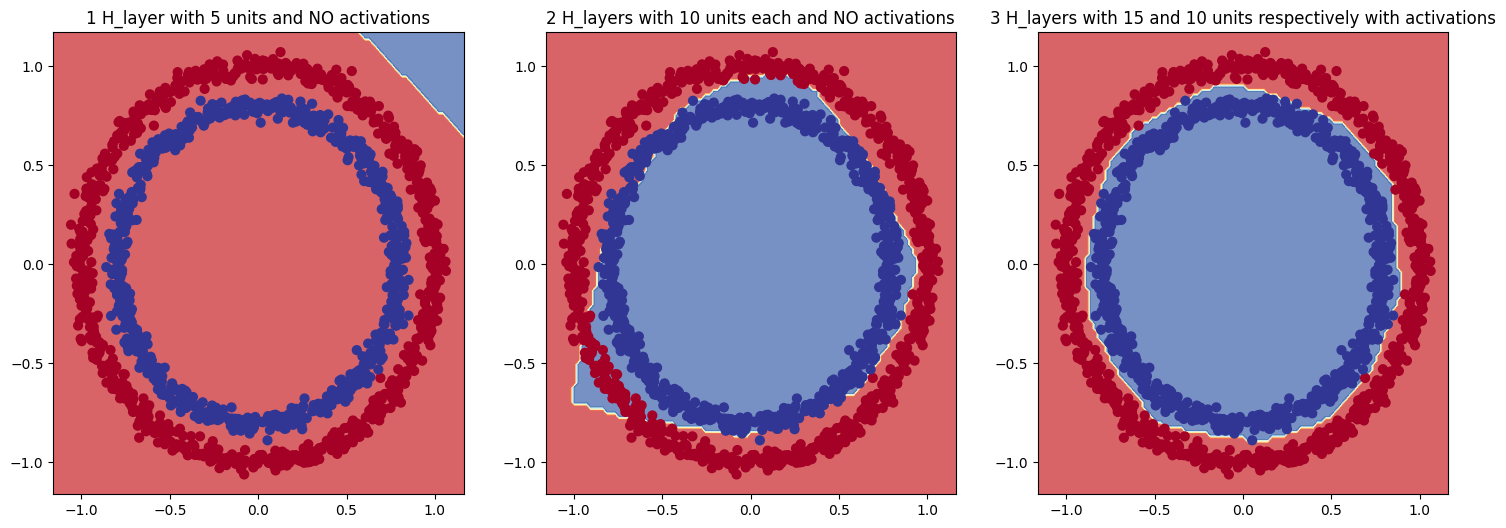

In [62]:
plt.figure(figsize = (18, 6))
plt.subplot(1, 3, 1)
plt.title("1 H_layer with 5 units and NO activations")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 3, 2)
plt.title("2 H_layers with 10 units each and NO activations")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 3, 3)
plt.title("3 H_layers with 15 and 10 units respectively with activations")
plot_decision_boundary(model_2, X_train, y_train)